## This notebook showcases how to generate map feature tags for a way

This approach is used for each way to map everything

In [32]:
import base64
import io
import json

import pandas as pd
import numpy as np
import cv2
import imutils
from PIL import Image
from shapely.wkt import loads
import matplotlib.pyplot as plt
from openai import NotGiven

from LLMClientFactory import LLMClientFactory

## constants

In [33]:
LLM_CLIENT = LLMClientFactory.get_client()
LLM_CONFIG = json.load(open('./llm_config.json', 'r'))
SQUARE_SIDE_DIMENSION = 1000
POS_Y = 500
POS_X = 1500
WIDTH = 4000

In [34]:
print(LLM_CONFIG['job_description'])

You are an expert at analyzing street-level images for road characteristics.
Focus only on the road segment where the vehicle is currently traveling.
    
Analyze the road segment to determine:

**Road Type:**
- One-way or two-way road

**Lane Count:**
- One-way: count total lanes
- Two-way: count lanes for each direction

**Directional Arrows:**
- Identify arrow markings on the road
- Record the sequence of arrows
- For two-way roads: provide arrows for each direction separately
- The sequence(s) must match exactly the lane count (in each direction if double way)

**Street Name:**
- Identify street name signs on the road

**Speed Limit:**
- One-way: speed limit for your driving direction
- Two-way: speed limit for each driving direction.


In [35]:
print(LLM_CONFIG['prompt'])

**Instructions:**
1. Analyze the image for:
   - Road type (one-way or two-way)
   - Lane count
   - Directional arrows
   - Street Name
   - Speed Limit
2. If no relevant features are visible, state: "No relevant features detected"
3. Aggregate features across all images of the road segment.
4. Provide final output in the specified format after reviewing all observations made throughout the road segment and ensuring consistency. Correct any earlier conclusions if new evidence contradicts them.
5. Include your detailed reasoning.

**JSON Output Format:**


One-way example: 
FINAL_OUTPUT: {'reasoning': 'your reasoning...'; 'oneway': 'yes'; 'lanes': '2'; 'turn:lanes': 'through|right'; 'name': 'St. X'; 'maxspeed': 25}

Two-way example: 
FINAL_OUTPUT: {'reasoning': 'your reasoning...'; 'oneway': 'no'; 'lanes:forward': '1'; 'lanes:backward': '1'; 'turn:lanes:forward': 'through'; 'turn:lanes:backward': None,  'name': 'St. X'; 'maxspeed:forward': 30,  'maxspeed:backward': 20}


In [36]:
print(LLM_CONFIG['aggregation_prompt'])

Based on all the images analyzed in this road segment sequence, provide a final consolidated analysis.
If the match direction of an entry is False, the tags must pe inverted between forward and backward direction.
Review all observations and ensure consistency. Correct any earlier conclusions if new evidence contradicts them.
Provide the final output in the specified format


## utils 

In [22]:
def load_metadata(file_path):
    df = pd.read_csv(file_path)
    if 'geometry' in df.columns and isinstance(df['geometry'].iloc[0], str):
        df['geometry'] = df['geometry'].apply(loads)
    if 'sequences' in df.columns and isinstance(df['sequences'].iloc[0], str):
        df['sequences'] = df['sequences'].apply(lambda x: eval(x))
    return df

def load_and_resize_image(sequence_id, sequence_index):
    image_filename = f"../photos/{sequence_id}_{sequence_index}.png"
    image = cv2.imread(image_filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = imutils.resize(image, width=WIDTH)
    return image

def get_front_view(image):
    return image[POS_Y:POS_Y+SQUARE_SIDE_DIMENSION, 
                 POS_X:POS_X+SQUARE_SIDE_DIMENSION]

def plot_image(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()

def get_photo_match_direction(sequence_id, sequence_index, photos_df):
    photo_entry = photos_df[(photos_df['sequence_id']==sequence_id)&(photos_df['sequence_index']==sequence_index)]
    assert photo_entry.shape[0] == 1, "Photo not found in photos.csv"
    return photo_entry['match_forward'].iloc[0]

def encode_image_from_array(image_array, input_format='RGB'):
    if image_array.dtype != np.uint8:
        image_array = (image_array * 255).astype(np.uint8)
    if input_format.upper() == 'BGR':
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    elif input_format.upper() not in ['RGB', 'BGR']:
        raise ValueError("output_format must be either 'RGB' or 'BGR'")
    
    image = Image.fromarray(image_array)
    buffer = io.BytesIO()
    image.save(buffer, format="PNG", optimize=True, compress_level=0)
    content_bytes = buffer.getvalue()
    return base64.b64encode(content_bytes).decode('utf-8')

def get_llm_prompt(prompt_text, images=None, conversation_history=None, first_step=False):
    conversation = []
    
    if first_step:
        conversation.append({
            "role": "system",
            "content": [{"type": "text", "text": LLM_CONFIG['job_description']}]
        })
    
    if conversation_history is not None:
        for message in conversation_history:
            
            if message["role"] == "assistant":
                conversation.append(message)

            elif message["role"] == "user":
                text_content = []
                for content in message["content"]:
                    if content["type"] == "text":
                        text_content.append(content)
                
                if text_content:
                    conversation.append({
                        "role": "user",
                        "content": text_content
                    })
    
    user_content = [{"type": "text", "text": prompt_text}]
    
    if images is not None:
        for img in images:
            img_dict = {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encode_image_from_array(img)}"}}
            user_content.append(img_dict)
    
    conversation.append({
        "role": "user",
        "content": user_content
    })
    
    return conversation

def call_api(messages):
    try:
        response = LLM_CLIENT.chat.completions.create(
            model=LLM_CONFIG['model'],
            messages=messages,
            max_tokens=LLM_CONFIG['max_tokens'],
            temperature=LLM_CONFIG['temperature'],
            response_format = {'type': 'json_object'} if LLM_CONFIG['return_json'] else NotGiven(),
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error calling API: {e}")
        return None

def update_conversation_history(conversation_history, new_messages, response_content):
    """
    Update conversation history with new messages and response
    """
    if conversation_history is None:
        conversation_history = []
    
    # Add the new user message (without images to save memory)
    user_message = None
    for msg in new_messages:
        if msg["role"] == "user":
            # Keep only text content, remove images to save memory
            text_content = [content for content in msg["content"] if content["type"] == "text"]
            if text_content:
                user_message = {
                    "role": "user",
                    "content": text_content
                }
            break
    
    if user_message:
        conversation_history.append(user_message)
    
    # Add the assistant's response
    if response_content:
        conversation_history.append({
            "role": "assistant",
            "content": [{"type": "text", "text": response_content}]
        })
    
    return conversation_history

def analyze_road_sequence(ways_df, photos_df, osm_id_example, load_and_resize_image, get_front_view, verbose=False):
    """
    Main function to analyze road sequences with conversation history
    """
    ways_df_example = ways_df[ways_df['osmid']==osm_id_example]
    sequences_ways_df_example = ways_df_example['sequences'].iloc[0]

    results = {osm_id_example: []}
    
    for sequence_id, sequence_indexes in sequences_ways_df_example.items():
        print(f"Processing sequence: {sequence_id}")
        conversation_history = None
        sequence_results = []
        
        for i, sequence_index in enumerate(sequence_indexes):
            try:
                image = load_and_resize_image(sequence_id, sequence_index)
                front_view = get_front_view(image)
                
                if verbose:
                    plot_image(front_view)

                is_first_step = (i == 0)
                prompt_text = LLM_CONFIG['prompt']
                
                # Get conversation messages
                messages = get_llm_prompt(
                    prompt_text=prompt_text,
                    images=[front_view],
                    conversation_history=conversation_history,
                    first_step=is_first_step
                )
                
                # Call LLM
                response = call_api(messages)
                
                if response:
                    print(f"  Image {sequence_index}: {response}")
                    sequence_results.append({
                        'sequence_index': sequence_index,
                        'match_direction': get_photo_match_direction(sequence_id, sequence_index, photos_df),
                        'response': response
                    })
                    
                    # Update conversation history
                    conversation_history = update_conversation_history(
                        conversation_history, messages, response
                    )
                else:
                    print(f"  Image {sequence_index}: Failed to get response")
                    
            except Exception as e:
                print(f"  Error processing image {sequence_index}: {e}")
                continue
        
        # Get final summary for the sequence
        if conversation_history:
            try:
                final_messages = get_llm_prompt(
                    prompt_text=LLM_CONFIG['aggregation_prompt'],
                    images=None,
                    conversation_history=conversation_history,
                    first_step=False
                )
                
                final_response = call_api(final_messages)
                
                if final_response:
                    sequence_results.append({
                        'sequence_index': 'FINAL_SUMMARY',
                        'response': final_response
                    })
                    print(f"  Final summary: {final_response}")
                
            except Exception as e:
                print(f"  Error getting final summary: {e}")
        
        # results[sequence_id] = sequence_results
        results[osm_id_example].append({sequence_id:sequence_results})
    
    return results

## Load metadata

In [23]:
ways_df = load_metadata('../metadata/ways.csv')
photos_df = load_metadata('../metadata/photos.csv')

# example osm id for which we want to extract map attributes from a sequence of images collected along the way
osm_id_example = 1329887723

## Predict

Processing sequence: 34523248


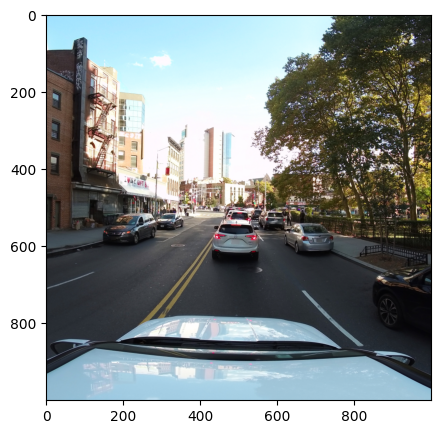

  Image 491: {
    "reasoning": "The image shows a two-way road with a double yellow line separating the directions. There are two lanes in each direction. No directional arrows are visible on the road. No street name signs or speed limit signs are visible.",
    "oneway": "no",
    "lanes:forward": "2",
    "lanes:backward": "2",
    "turn:lanes:forward": null,
    "turn:lanes:backward": null,
    "name": null,
    "maxspeed:forward": null,
    "maxspeed:backward": null
}


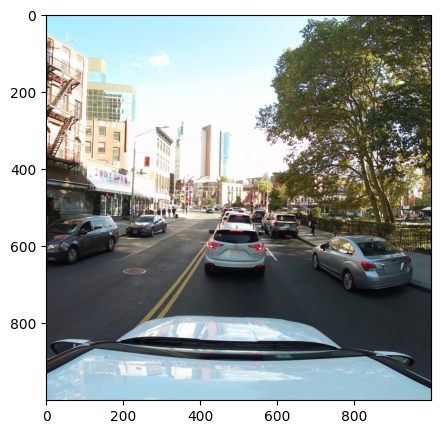

  Image 492: {
    "reasoning": "The image shows a two-way road with a double yellow line separating the directions. There are two lanes in each direction. No directional arrows are visible on the road. No street name signs or speed limit signs are visible.",
    "oneway": "no",
    "lanes:forward": "2",
    "lanes:backward": "2",
    "turn:lanes:forward": null,
    "turn:lanes:backward": null,
    "name": null,
    "maxspeed:forward": null,
    "maxspeed:backward": null
}


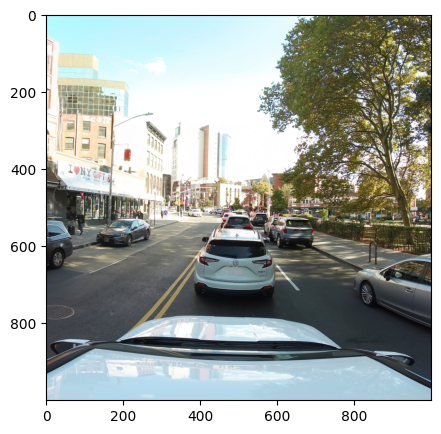

  Image 493: {
    "reasoning": "The image shows a two-way road with a double yellow line separating the directions. There are two lanes in each direction, as indicated by the visible lane markings and traffic flow. No directional arrows are visible on the road. The street name is not visible, and there are no speed limit signs present.",
    "oneway": "no",
    "lanes:forward": "2",
    "lanes:backward": "2",
    "turn:lanes:forward": null,
    "turn:lanes:backward": null,
    "name": null,
    "maxspeed:forward": null,
    "maxspeed:backward": null
}


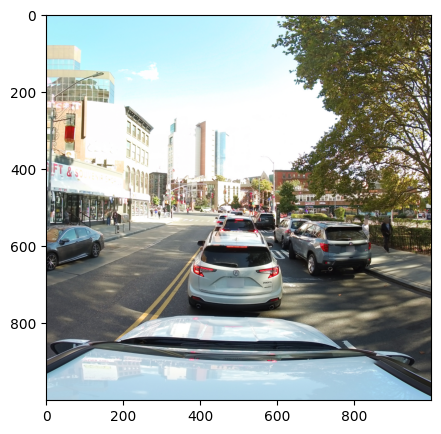

  Image 494: {
    "reasoning": "The image shows a two-way road with a double yellow line separating the directions. There are two lanes in each direction, as indicated by the visible lane markings and traffic flow. No directional arrows are visible on the road. The street name is not visible, and there are no speed limit signs present.",
    "oneway": "no",
    "lanes:forward": "2",
    "lanes:backward": "2",
    "turn:lanes:forward": null,
    "turn:lanes:backward": null,
    "name": null,
    "maxspeed:forward": null,
    "maxspeed:backward": null
}


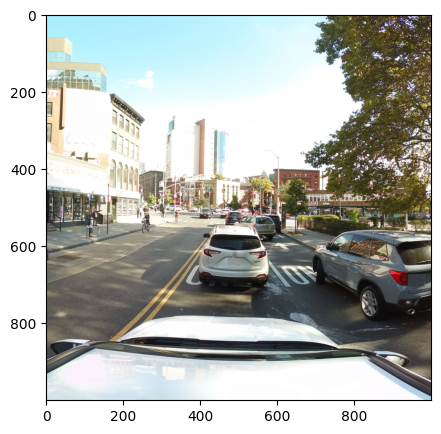

  Image 495: {
    "reasoning": "The image shows a two-way road with a double yellow line separating the directions. There are two lanes in each direction, as indicated by the visible lane markings. Directional arrows indicate a right turn lane. The street name is not visible, and there are no speed limit signs present.",
    "oneway": "no",
    "lanes:forward": "2",
    "lanes:backward": "2",
    "turn:lanes:forward": "through|right",
    "turn:lanes:backward": null,
    "name": null,
    "maxspeed:forward": null,
    "maxspeed:backward": null
}


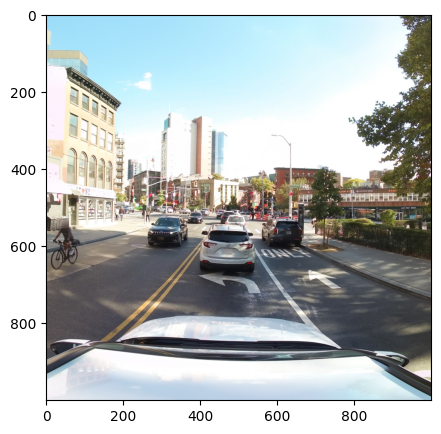

  Image 496: {
    "reasoning": "The image shows a two-way road with a double yellow line separating the directions. There are two lanes in each direction. The right lane has directional arrows indicating a right turn only. No street name signs or speed limit signs are visible.",
    "oneway": "no",
    "lanes:forward": "2",
    "lanes:backward": "2",
    "turn:lanes:forward": "left|right",
    "turn:lanes:backward": null,
    "name": null,
    "maxspeed:forward": null,
    "maxspeed:backward": null
}
  Final summary: {
    "reasoning": "After reviewing all images in the road segment sequence, the road is confirmed to be a two-way road with a consistent double yellow line separating the directions. Each direction has two lanes. Directional arrows indicate that the right lane in the forward direction is a right-turn-only lane. No street name signs or speed limit signs were visible in any of the images. Since the match direction of an entry is False, the forward and backward tags need to

In [24]:
results = analyze_road_sequence(
    ways_df, 
    photos_df,
    osm_id_example, 
    load_and_resize_image, 
    get_front_view,
    verbose=True
)

In [29]:
gt_df = load_metadata('../metadata/ground_truth.csv')
gt_df_example = gt_df[gt_df['osmid']==osm_id_example]
gt_df_example

,osmid,oneway,name,lanes,lanes:forward,lanes:backward,turn:lanes,turn:lanes:forward,turn:lanes:backward,maxspeed,maxspeed:forward
40,1329887723,NaN,Worth Street,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN
